In [2]:
#Cell1
import pandas as pd
import numpy as np

PATH = r"D:\DataScience\AirQuality.csv"

# 1) 读入（这个数据集是 ; 分隔）
df = pd.read_csv(PATH, sep=";", engine="python")
df = df.dropna(axis=1, how="all")          # 去掉最后那列全空的

print("After read:", df.shape)
print(df[["Date","Time"]].head())

# 2) -200 视为缺失
df = df.replace(-200, np.nan)

# 3) 组合 datetime（关键：明确指定格式！）
df["Date"] = df["Date"].astype(str).str.strip()
df["Time"] = df["Time"].astype(str).str.strip()
dt_str = df["Date"] + " " + df["Time"]

df["datetime"] = pd.to_datetime(
    dt_str,
    format="%d/%m/%Y %H.%M.%S",   # 注意这里的点
    errors="coerce"
)

print("datetime parsed OK rows:", df["datetime"].notna().sum(), "/", len(df))
print(df.loc[df["datetime"].isna(), ["Date","Time"]].head())  # 看看失败长啥样

# 4) 再删掉解析失败的行
df = df.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)

print("After datetime clean:", df.shape)
df.head()


After read: (9471, 15)
         Date      Time
0  10/03/2004  18.00.00
1  10/03/2004  19.00.00
2  10/03/2004  20.00.00
3  10/03/2004  21.00.00
4  10/03/2004  22.00.00
datetime parsed OK rows: 9357 / 9471
     Date Time
9357  nan  nan
9358  nan  nan
9359  nan  nan
9360  nan  nan
9361  nan  nan
After datetime clean: (9357, 16)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",2004-03-10 18:00:00
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",2004-03-10 19:00:00
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",2004-03-10 20:00:00
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",2004-03-10 21:00:00
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",2004-03-10 22:00:00


In [3]:
# CL2 (新版): 缺失率 + 关键列检查（EDA）

print("Shape:", df.shape)
print("Datetime nulls:", df["datetime"].isna().sum())
print("Date nulls:", df["Date"].isna().sum(), " Time nulls:", df["Time"].isna().sum())

# 1) 每列缺失率（%）
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("\nTop missing columns (%):")
print(missing_pct.round(2).head(20))

# 2) 你们目标列 NO2(GT) 缺失情况（最重要）
if "NO2(GT)" in df.columns:
    print("\nNO2(GT) missing %:", round(df["NO2(GT)"].isna().mean() * 100, 2))
    print("NO2(GT) non-null count:", df["NO2(GT)"].notna().sum())

# 3) 看看 -200 是否真的都被处理掉了（可选）
neg200_cnt = (df == -200).sum(numeric_only=False)
if neg200_cnt.sum() > 0:
    print("\nWARNING: still has -200 values! Top columns:")
    print(neg200_cnt[neg200_cnt > 0].sort_values(ascending=False).head(10))
else:
    print("\nOK: no -200 remaining.")


Shape: (9357, 16)
Datetime nulls: 0
Date nulls: 0  Time nulls: 0

Top missing columns (%):
NMHC(GT)         90.23
NO2(GT)          17.55
NOx(GT)          17.52
PT08.S1(CO)       3.91
PT08.S5(O3)       3.91
PT08.S4(NO2)      3.91
PT08.S3(NOx)      3.91
PT08.S2(NMHC)     3.91
C6H6(GT)          0.00
Date              0.00
Time              0.00
CO(GT)            0.00
T                 0.00
RH                0.00
AH                0.00
datetime          0.00
dtype: float64

NO2(GT) missing %: 17.55
NO2(GT) non-null count: 7715

OK: no -200 remaining.


In [6]:
# CL3 (新版): Table 1 - Data types & Missingness

import pandas as pd

table1 = pd.DataFrame({
    "Feature": df.columns,
    "Dtype": df.dtypes.astype(str),
    "Missing_Count": df.isna().sum(),
    "Missing_%": (df.isna().mean() * 100).round(2)
}).sort_values("Missing_%", ascending=False).reset_index(drop=True)

print("Table 1 - Data types & Missingness (top 20 rows):")
display(table1.head(20))

# 可选：导出，方便粘贴进报告/共享给队友
# table1.to_csv("Table1_DataTypes_Missing.csv", index=False)


Table 1 - Data types & Missingness (top 20 rows):


,Feature,Dtype,Missing_Count,Missing_%
0,NMHC(GT),float64,8443,90.23
1,NO2(GT),float64,1642,17.55
2,NOx(GT),float64,1639,17.52
3,PT08.S1(CO),float64,366,3.91
4,PT08.S5(O3),float64,366,3.91
5,PT08.S4(NO2),float64,366,3.91
6,PT08.S3(NOx),float64,366,3.91
7,PT08.S2(NMHC),float64,366,3.91
8,C6H6(GT),object,0,0.00
9,Date,object,0,0.00


In [5]:
# Cell3: 根据缺失率做策略清洗（为后面按天聚合做准备）

drop_cols = ["NMHC(GT)"]   # 缺失 90%+，直接删
df2 = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()

# 目标是 NO2，所以只保留 NO2 有值的行（缺失的行不能训练/计算日均值）
df2 = df2.dropna(subset=["NO2(GT)"]).copy()

print("After drop cols + keep NO2 available:", df2.shape)
df2[["datetime","NO2(GT)"]].head()


After drop cols + keep NO2 available: (7715, 15)


,datetime,NO2(GT)
0,2004-03-10 18:00:00,113.0
1,2004-03-10 19:00:00,92.0
2,2004-03-10 20:00:00,114.0
3,2004-03-10 21:00:00,122.0
4,2004-03-10 22:00:00,116.0


In [13]:
import numpy as np
import pandas as pd

# ==============================
# Cell4: Build daily2 (daily features from ALL sensors) + target (next-day NO2 mean)
# ==============================

# 0) 防呆：确保 df2 有 datetime 列且为 datetime 类型
df2_tmp = df2.copy()

# 如果 datetime 不在列里但在 index，就 reset 出来
if "datetime" not in df2_tmp.columns and df2_tmp.index.name in ["datetime", "date", "DateTime", "Date_Time"]:
    df2_tmp = df2_tmp.reset_index()

# 尝试找到时间列名（你的情况基本就是 datetime）
time_col = None
for c in ["datetime", "date", "DateTime", "Date_Time"]:
    if c in df2_tmp.columns:
        time_col = c
        break
if time_col is None:
    raise ValueError("找不到时间列：需要 df2 里有 datetime（或 date/DateTime）")

df2_tmp[time_col] = pd.to_datetime(df2_tmp[time_col], errors="coerce")
df2_tmp = df2_tmp.dropna(subset=[time_col]).sort_values(time_col)

# 1) 把可能还是 object 的“数字列”强制转成 numeric
#    (比如 CO(GT), C6H6(GT), T, RH, AH 有时会是字符串/逗号小数)
for c in df2_tmp.columns:
    if c in [time_col, "Date", "Time"]:
        continue
    if df2_tmp[c].dtype == "object":
        # 处理 2,6 这种逗号小数
        df2_tmp[c] = df2_tmp[c].astype(str).str.replace(",", ".", regex=False)
        df2_tmp[c] = pd.to_numeric(df2_tmp[c], errors="coerce")

# 2) 选“所有数值列”（除了时间列），按天求 mean —— 这就是“其他化学物质对次日NO2影响”的特征来源
num_cols = [c for c in df2_tmp.columns
            if c not in [time_col, "Date", "Time"] and pd.api.types.is_numeric_dtype(df2_tmp[c])]

# 按天聚合：所有数值列 -> 日均值
daily2 = (
    df2_tmp.set_index(time_col)[num_cols]
          .groupby(pd.Grouper(freq="D"))
          .mean()
          .reset_index()
          .rename(columns={time_col: "date"})
)

# 3) 计算每天 NO2(GT) 有多少小时数据（用于筛“有效天”）
if "NO2(GT)" not in df2_tmp.columns:
    raise ValueError("df2 里没有 NO2(GT)，无法构造目标 y_nextday_no2_mean")

hours = (
    df2_tmp.set_index(time_col)["NO2(GT)"]
          .groupby(pd.Grouper(freq="D"))
          .count()
          .reset_index()
          .rename(columns={time_col: "date", "NO2(GT)": "hours"})
)

daily2 = daily2.merge(hours, on="date", how="left")

# 4) 目标 y：次日 NO2 的日均值
#    这里用“当天 NO2(GT) 日均值”来 shift(-1) 得到“次日”
daily2 = daily2.sort_values("date").reset_index(drop=True)
daily2["y_nextday_no2_mean"] = daily2["NO2(GT)"].shift(-1)

# 5) 过滤：小时数不足的天 -> 置空（跟你之前逻辑一致）
min_hours = 20
daily2.loc[daily2["hours"] < min_hours, "NO2(GT)"] = np.nan
daily2.loc[daily2["hours"] < min_hours, "y_nextday_no2_mean"] = np.nan

# 6) 建模/相关性用的数据：去掉 y 或 NO2 缺失的行
daily2_model = daily2.dropna(subset=["NO2(GT)", "y_nextday_no2_mean"]).copy()

print("daily2 shape:", daily2.shape)
print("daily2_model shape:", daily2_model.shape)
daily2_model.head()


daily2 shape: (391, 15)
daily2_model shape: (320, 15)


,date,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hours,y_nextday_no2_mean
1,2004-03-11,-6.482609,1254.347826,8.252174,864.608696,144.391304,1258.652174,99.869565,1535.347826,901.956522,9.817391,64.243478,0.776813,23,116.272727
2,2004-03-12,-6.322727,1287.545455,12.140909,1012.363636,173.727273,1090.818182,116.272727,1627.727273,1087.500000,11.577273,50.354545,0.665105,22,118.869565
3,2004-03-13,-6.073913,1337.565217,11.156522,1001.956522,184.434783,985.130435,118.869565,1605.173913,1256.782609,13.086957,50.839130,0.732948,23,110.391304
4,2004-03-14,-6.330435,1361.869565,9.634783,942.869565,146.608696,1004.782609,110.391304,1601.608696,1232.304348,16.204348,48.217391,0.848900,23,118.739130
5,2004-03-15,-5.239130,1468.434783,16.600000,1156.521739,215.130435,833.347826,118.739130,1906.086957,1457.260870,17.573913,49.747826,0.944943,23,118.173913


In [15]:
# Cell5: 构造预测目标 y = 次日 NO2 日均值
# 目标：用“今天的信息”预测“明天的 no2_mean”

#daily2 = daily.copy()

# 按日期排序（非常重要，shift 才不会乱）
daily2 = daily2.sort_values("date").reset_index(drop=True)

# y：次日的 NO2 日均值（shift(-1) 表示往上挪一行）
daily2["y_nextday_no2_mean"] = daily2["NO2(GT)"].shift(-1)

# 丢掉：今天缺 no2_mean 或 明天缺 y 的行
daily2 = daily2.dropna(subset=["NO2(GT)", "y_nextday_no2_mean"]).copy()

print("After dropping NA rows:", daily2.shape)
daily2.head()


After dropping NA rows: (304, 15)


,date,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hours,y_nextday_no2_mean
1,2004-03-11,-6.482609,1254.347826,8.252174,864.608696,144.391304,1258.652174,99.869565,1535.347826,901.956522,9.817391,64.243478,0.776813,23,116.272727
2,2004-03-12,-6.322727,1287.545455,12.140909,1012.363636,173.727273,1090.818182,116.272727,1627.727273,1087.500000,11.577273,50.354545,0.665105,22,118.869565
3,2004-03-13,-6.073913,1337.565217,11.156522,1001.956522,184.434783,985.130435,118.869565,1605.173913,1256.782609,13.086957,50.839130,0.732948,23,110.391304
4,2004-03-14,-6.330435,1361.869565,9.634783,942.869565,146.608696,1004.782609,110.391304,1601.608696,1232.304348,16.204348,48.217391,0.848900,23,118.739130
5,2004-03-15,-5.239130,1468.434783,16.600000,1156.521739,215.130435,833.347826,118.739130,1906.086957,1457.260870,17.573913,49.747826,0.944943,23,118.173913


In [16]:
# Cell6: Baseline (Tomorrow = Today)
# 最简单的预测：预测明天的 NO2 日均值 = 今天的 NO2 日均值
# 用它当“最低标准”，后面的模型必须超过它才算有价值

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = daily2["y_nextday_no2_mean"]   # 真实的“明天”
y_pred = daily2["NO2(GT)"]             # 预测的“明天” = “今天”

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("=== Baseline (Tomorrow = Today) ===")
print(f"MAE  : {mae:.3f}   (平均绝对误差，越小越好)")
print(f"RMSE : {rmse:.3f}  (更惩罚大误差，越小越好)")
print(f"R2   : {r2:.3f}    (解释方差比例，越接近1越好)")


=== Baseline (Tomorrow = Today) ===
MAE  : 16.913   (平均绝对误差，越小越好)
RMSE : 21.992  (更惩罚大误差，越小越好)
R2   : 0.552    (解释方差比例，越接近1越好)


In [17]:
#Table 2: Summary statistics (daily-level features)

import numpy as np
import pandas as pd

# 1) 选择要做统计的数值列（排除 date；y是否一起统计看你们写作习惯）
num_cols = daily2.select_dtypes(include=[np.number]).columns.tolist()

# 2) describe: count/mean/std/min/25%/50%/75%/max
table2 = daily2[num_cols].describe().T

# 3) 加上缺失率，报告更完整
table2["missing_%"] = (daily2[num_cols].isna().mean() * 100).round(2)

# 4) 排序：通常按 missing_% 或者按你们最关心的变量
table2 = table2.sort_values("missing_%", ascending=False)

print("Table 2 - Summary statistics (all numeric columns):")
display(table2)

# 可选导出
# table2.to_csv("Table2_SummaryStats_Daily.csv")


Table 2 - Summary statistics (all numeric columns):


,count,mean,std,min,25%,50%,75%,max,missing_%
PT08.S1(CO),297.0,1112.768320,145.382377,725.608696,1002.695652,1107.652174,1216.541667,1532.173913,2.3
PT08.S2(NMHC),297.0,948.117990,154.958480,526.652174,840.565217,955.260870,1061.954545,1376.695652,2.3
PT08.S3(NOx),297.0,823.341001,180.339417,500.304348,691.478261,803.695652,923.521739,1684.652174,2.3
PT08.S4(NO2),297.0,1439.753379,287.462045,705.173913,1238.478261,1474.652174,1667.086957,1938.434783,2.3
PT08.S5(O3),297.0,1051.507758,292.119216,382.217391,843.173913,1039.652174,1231.826087,2043.666667,2.3
CO(GT),304.0,-8.771020,31.835877,-200.000000,-6.698913,0.678261,2.215062,5.421739,0.0
NOx(GT),304.0,252.961217,158.167859,33.608696,131.934783,203.784585,356.716938,847.434783,0.0
C6H6(GT),304.0,1.438541,38.540083,-200.000000,6.114130,9.291304,13.085870,24.617391,0.0
NO2(GT),304.0,114.780873,32.629075,38.043478,91.858696,111.739130,134.108696,223.347826,0.0
T,304.0,8.415038,40.528118,-200.000000,9.059620,15.922917,23.252174,33.334783,0.0


In [ ]:
# Cell7: 可视化 NO2 日均值的时间变化和分布
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 建议用 daily2：它已经去掉了 no2_mean 或 nextday 为空的天
plot_df = daily2.copy()

# 确保 date 是 datetime 类型（有些时候你 rename 过）
plot_df["date"] = pd.to_datetime(plot_df["date"])

# ===== 图1：NO2 日均值随时间变化（折线图） =====
plt.figure()
plt.plot(plot_df["date"], plot_df["no2_mean"])
plt.title("Daily NO2 mean over time")
plt.xlabel("Date")
plt.ylabel("NO2 daily mean")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===== 图2：按月份分布（箱线图） =====
plot_df["month"] = plot_df["date"].dt.month

data_by_month = [plot_df.loc[plot_df["month"] == m, "no2_mean"].values for m in range(1, 13)]

plt.figure()
plt.boxplot(data_by_month, labels=list(range(1, 13)))
plt.title("NO2 daily mean by month")
plt.xlabel("Month")
plt.ylabel("NO2 daily mean")
plt.tight_layout()
plt.show()


Top POSITIVE correlations with next-day NO2:
NOx(GT)          0.545821
PT08.S5(O3)      0.345854
PT08.S1(CO)      0.173798
CO(GT)           0.078492
hours            0.076759
PT08.S2(NMHC)    0.060680
dtype: float64

Top NEGATIVE correlations with next-day NO2:
PT08.S4(NO2)   -0.501414
T              -0.250084
PT08.S3(NOx)   -0.223282
AH             -0.155360
C6H6(GT)       -0.140371
RH             -0.129570
dtype: float64


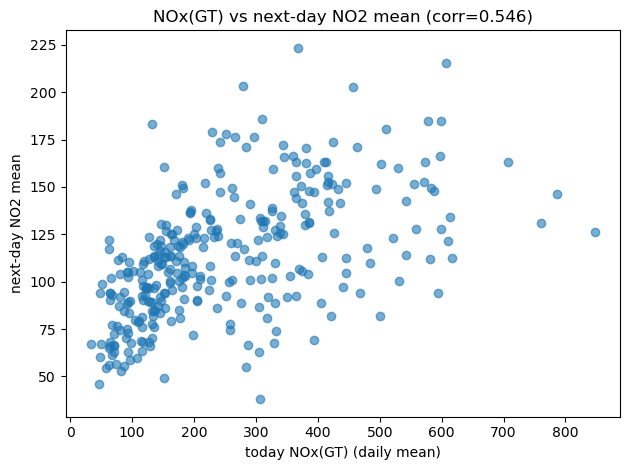

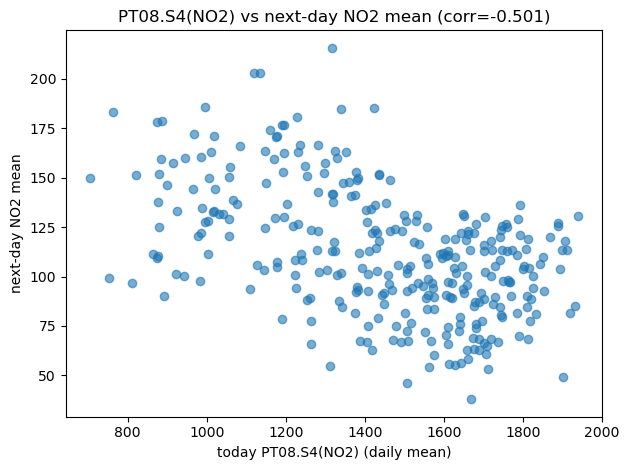

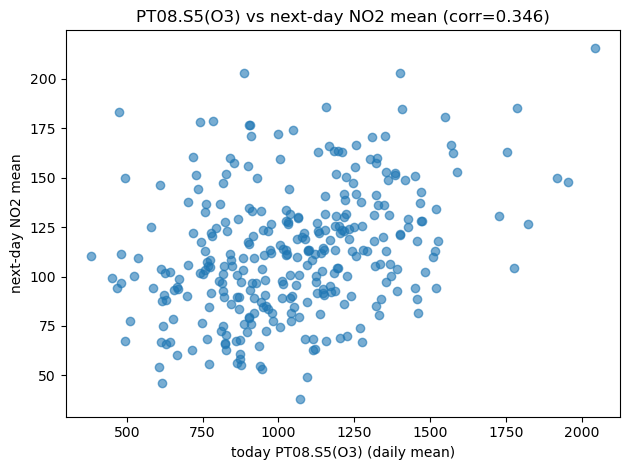

In [18]:
import matplotlib.pyplot as plt

# ==============================
# Cell8: Correlation (today features vs next-day NO2)
# ==============================

df_corr = daily2_model.copy()
target = "y_nextday_no2_mean"

# 特征列：所有数值列里，去掉 target、去掉当天 NO2(GT)（否则它往往最强，意义不大）
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in [target, "NO2(GT)"]]

corr_series = df_corr[feature_cols].corrwith(df_corr[target]).sort_values(ascending=False)

pos = corr_series[corr_series > 0].sort_values(ascending=False)
neg = corr_series[corr_series < 0].sort_values(ascending=True)

print("Top POSITIVE correlations with next-day NO2:")
print(pos.head(10))

print("\nTop NEGATIVE correlations with next-day NO2:")
print(neg.head(10) if len(neg) else "None (no negative correlations)")

# 画 3 个“绝对值最大”的相关特征散点图
top3 = corr_series.dropna().abs().sort_values(ascending=False).head(3).index.tolist()

for col in top3:
    plt.figure()
    plt.scatter(df_corr[col], df_corr[target], alpha=0.6)
    plt.title(f"{col} vs next-day NO2 mean (corr={corr_series[col]:.3f})")
    plt.xlabel(f"today {col} (daily mean)")
    plt.ylabel("next-day NO2 mean")
    plt.tight_layout()
    plt.show()
